# Import data and libraries

In [15]:
# Import relevant Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from linearmodels import IV2SLS

In [16]:
# Read the Fulton Fish market dataset
with open('Fulton_fish_market_dataset.txt') as infile:
    # Read space-delimited file and replace all empty spaces by commas
    data = infile.read().replace(' ', ',')
    # Write the CSV data in the output file
    print(data, file=open('my_file.csv', 'w'))

# Open the dataframe
df = pd.read_csv("my_file.csv", sep="\t")

# Naively explore the price-quantity relationship

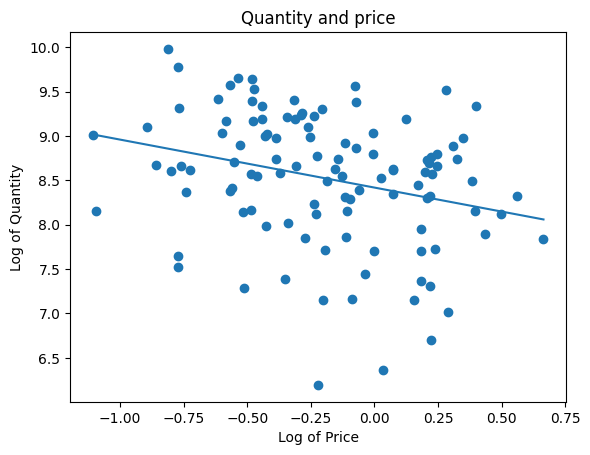

In [21]:
# Indicate the variables of interest
x= df["price"]
y= df["qty"]

# Let's try to understand the price-quantity relationship
plt.scatter(df["price"], df["qty"])
plt.xlabel("Log of Price")
plt.ylabel("Log of Quantity")
plt.title("Quantity and price")
plt.plot(np.unique(df["price"]), np.poly1d(np.polyfit(df["price"], df["qty"], 1))(np.unique(df["price"])))
plt.show()

We observe a weak negative price-quantity correlation. However, currently no consideration is given to the time dimension of the data. 

<AxesSubplot: title={'center': 'number of items sold and revenue over time'}, xlabel='date'>

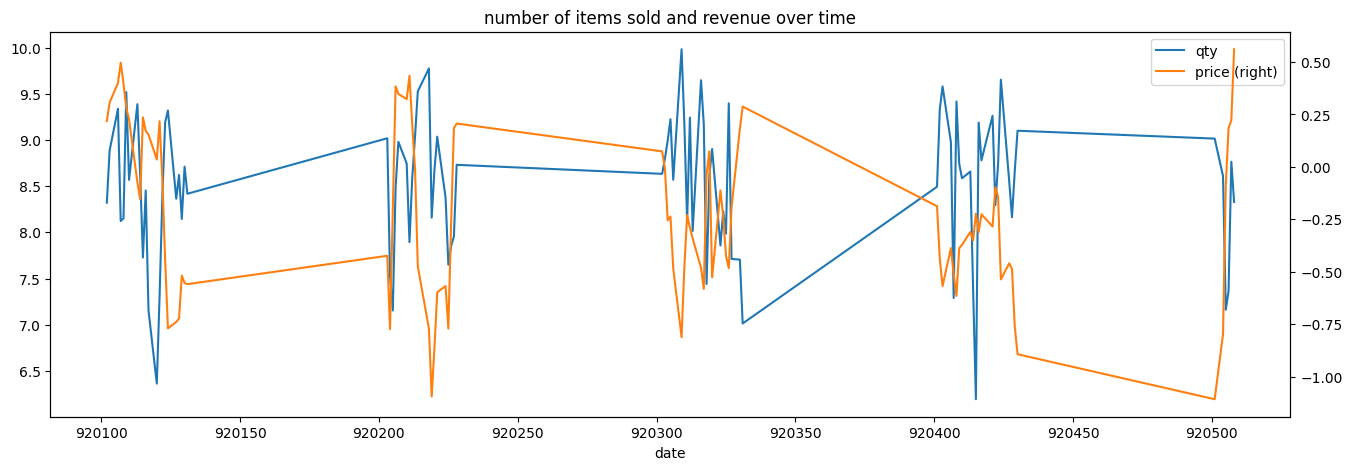

In [22]:
# Let's plot a time series evolution of quantity-price observations
# df.groupby('date').agg({'qty': 'sum', 'price': 'sum'}).plot(title='number of items sold and revenue over time', secondary_y='price',figsize=(16, 5))
# Let's skip earlier data points to get a rather smooth time series
df1=df.loc[df["date"]>911231] #we lose 21 observations
df1.groupby('date').agg({'qty': 'sum', 'price': 'sum'}).plot(title='number of items sold and revenue over time', secondary_y='price',figsize=(16, 5))

In contrast to the earlier observation, this graph suggests a strong negative relationship between price and quantity

# Formal investigation

## OLS estimates

In [23]:

# Now let's study the relationship more formally
# Linear Regression Model
# add an intercept to our model (beta_0)
df['const'] = 1

# Fit ols and print summary
results_ols = sm.OLS(df['qty'],
                    df[['const', 'price']]).fit()
print(results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     9.167
Date:                Thu, 08 Dec 2022   Prob (F-statistic):            0.00308
Time:                        16:58:31   Log-Likelihood:                -119.35
No. Observations:                 111   AIC:                             242.7
Df Residuals:                     109   BIC:                             248.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4187      0.076    110.445      0.0

## IV estimates
### First stage regressions
#### Lets first visualize the first stage graphically

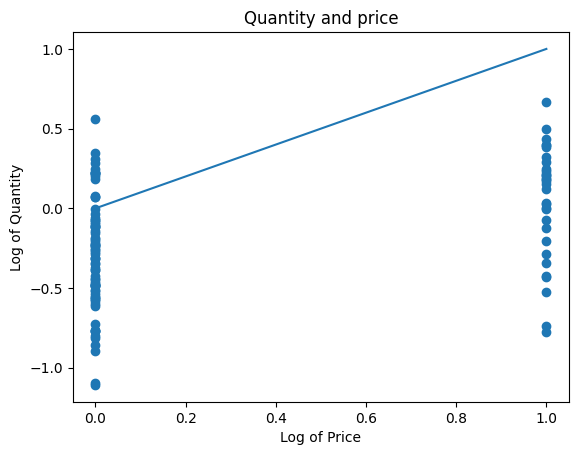

In [24]:
plt.scatter(df["stormy"], df["price"])
plt.xlabel("Log of Price")
plt.ylabel("Log of Quantity")
plt.title("Quantity and price")
plt.plot(np.unique(df["stormy"]), np.poly1d(np.polyfit(df["stormy"], df["stormy"], 1))(np.unique(df["stormy"])))
plt.show()

#### Now, lets investigate first stage more formally

In [25]:
# Fit the first stage regression and print summary
results_fs = sm.OLS(df['price'],
                    df[['const', 'stormy']],
                    missing='drop').fit()
print(results_fs.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     20.69
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           1.41e-05
Time:                        16:58:32   Log-Likelihood:                -40.516
No. Observations:                 111   AIC:                             85.03
Df Residuals:                     109   BIC:                             90.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2903      0.040     -7.336      0.0

In [26]:
### IV2SLS estimates

In [27]:
# Add a constant variable
results_iv = IV2SLS(dependent=df['qty'],
            exog=df['const'],
            endog=df['price'],
            instruments=df['stormy']).fit(cov_type='unadjusted')
print(results_iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                    qty   R-squared:                     -0.0002
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0094
No. Observations:                 111   F-statistic:                    5.5009
Date:                Thu, Dec 08 2022   P-value (F-stat)                0.0190
Time:                        16:58:33   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          8.3138     0.1136     73.194     0.0000      8.0912      8.5364
price         -1.0824     0.4615    -2.3454     0.01